<a href="https://colab.research.google.com/github/viniventur/previsao_artigo_HW_SARIMA/blob/main/template_holt_winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explicação:

A função a seguir roda todos os 4 modelos (add e mult na sazonalidade e tendência) para o dataframe fornecido de acordo com os parâmetros abaixo:



1. nome (str): Nome da previsão
2. df_completo (var): Dataframe com todos os dados
3. inicial_treino (str ou datatime): Data inicial dos dados de treino no formato YYYY-MM-DD
4. limite_treino (str ou datatime): Data limite dos dados de treino no formato YYYY-MM-DD
5. periodos_season (int): Períodos referentes a sazonalidade
6. numero_previsao (int): Número de observações a serem previstas

A função retorna o nome das variáveis criadas para a previsão de cada modelo específico contendo os dados concatenados (treino e previsto).




In [1]:
def previsao_hw(nome , df_completo, inicial_treino, limite_treino, periodos_season, numero_previsao):

  '''
  A função a seguir roda todos os 4 modelos (add e mult na sazonalidade e tendência) para o dataframe fornecido de acordo com os parâmetros abaixo:

  Argumentos:

  1. nome (str): Nome da previsão
  2. df_completo (var): Dataframe com todos os dados
  3. inicial_treino (str ou datatime): Data inicial dos dados de treino no formato YYYY-MM-DD
  4. limite_treino (str ou datatime): Data limite dos dados de treino no formato YYYY-MM-DD
  5. periodos_season (int): Períodos referentes a sazonalidade
  6. numero_previsao (int): Número de observações a serem previstas

  Retorno:

  Lista com os nomes das variáveis criadas para a previsão de cada modelo específico e as variáveis dos modelos individualmente contendo os dados concatenados (treino e previsto).
  '''

  # Ajustando a base de treino e real
  df_treino = df_completo.loc[(df_completo.index >= inicial_treino) & (df_completo.index <= limite_treino)]
  df_real = df_completo.loc[(df_completo.index > limite_treino)]
  df_prev_1 = pd.DataFrame(df_treino) # transformando em df caso apenas uma serie seja retornada

  # Realizando a previsão

  modelos_dic = {'df_prev_aa': ['add', 'add'], 'df_prev_am': ['add', 'mul'], 'df_prev_mm': ['mul', 'mul'], 'df_prev_ma': ['mul', 'add']}


  for i in df_prev_1.columns:

    for nome_df, modelos in modelos_dic.items():

      modelo = ExponentialSmoothing(
                                  df_prev_1[i],
                                  seasonal_periods=periodos_season,
                                  trend=modelos[0],
                                  seasonal=modelos[1],
                                  use_boxcox=True, # verificar depois pq usar boxcox
                                  initialization_method="estimated",
                                  ).fit()
      previsao = modelo.forecast(numero_previsao)
      df_prev_2 = pd.concat([df_treino, previsao], axis=0)
      df_prev_2 = pd.DataFrame(df_prev_2, columns=df_prev_1.columns)
      globals()[nome + "_" + nome_df] = df_prev_2

  global lista_modelos
  lista_modelos = []
  for i in modelos_dic.keys():
      lista_modelos.append(nome + "_" + i)

  def nomes(modelos_dic):
    print('Variaveis criadas: \n')
    print("Lista: lista_modelos \n")
    print("Contendo as variaveis: \n")
    for i in modelos_dic.keys():
      print(nome + "_" + i)

  return nomes(modelos_dic)

# Exemplo:

## Baixando pacotes

In [60]:
# Pacotes de gerenciamento do sistema operacional, como manipulação de arquivos e diretórios, gerenciamento de processos, obtenção de informações do sistema, etc.
import os
from google.colab import drive
drive.mount('/content/drive')

# Pacotes para manipulação e tratamento de dados
import numpy as np
import pandas as pd
from datetime import datetime

# Pacotes para análise gráfica
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import matplotlib.ticker as mticker
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Pacotes para análise econométrica
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# ES e Holt-Winters
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from statsmodels.tsa.seasonal import seasonal_decompose

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Tratando dados

In [19]:
df = pd.read_excel("/content/drive/MyDrive/Gerência de Estudos e Projeções/Dados/Impostos/Impostos - ICMS - ITCD - IPVA - IRRF - 1999 - 2024.xlsx", sheet_name='dados_1999_2024')
df['Total'] = df.ICMS + df.IPVA + df.IRRF + df.ITCD
df

,ANO,MES,ICMS,IPVA,ITCD,IRRF,Total
0,1999,1,4.035843e+07,658956.65,21163.97,3.293230e+03,4.104184e+07
1,1999,2,3.894808e+07,1032605.36,13089.30,8.150040e+03,4.000192e+07
2,1999,3,3.194334e+07,2489990.52,26279.08,0.000000e+00,3.445961e+07
3,1999,4,3.415198e+07,1851256.22,42705.30,0.000000e+00,3.604594e+07
4,1999,5,3.282836e+07,1905139.44,27892.99,0.000000e+00,3.476139e+07
...,...,...,...,...,...,...,...
302,2024,3,6.412978e+08,46837316.37,3990607.28,7.723583e+07,7.693616e+08
303,2024,4,6.901577e+08,64609203.08,4789282.70,8.712705e+07,8.466832e+08
304,2024,5,6.356771e+08,73725244.53,4528985.51,9.139155e+07,8.053229e+08
305,2024,6,6.307851e+08,71891371.15,5737256.86,1.084689e+08,8.168826e+08


In [20]:
# Limpando a base

df.dropna(inplace=True)
df['Data'] = pd.to_datetime(df['ANO'].astype(str) + '-' + df['MES'].astype(str))
df = df.set_index("Data")
df = df.drop(['MES', 'ANO'], axis=1)
df

,ICMS,IPVA,ITCD,IRRF,Total
Data,,,,,
1999-01-01,4.035843e+07,658956.65,21163.97,3.293230e+03,4.104184e+07
1999-02-01,3.894808e+07,1032605.36,13089.30,8.150040e+03,4.000192e+07
1999-03-01,3.194334e+07,2489990.52,26279.08,0.000000e+00,3.445961e+07
1999-04-01,3.415198e+07,1851256.22,42705.30,0.000000e+00,3.604594e+07
1999-05-01,3.282836e+07,1905139.44,27892.99,0.000000e+00,3.476139e+07
...,...,...,...,...,...
2024-02-01,6.385334e+08,40180682.59,5812958.30,8.310542e+07,7.676325e+08
2024-03-01,6.412978e+08,46837316.37,3990607.28,7.723583e+07,7.693616e+08
2024-04-01,6.901577e+08,64609203.08,4789282.70,8.712705e+07,8.466832e+08


## Rodando a previsão para 16 meses após agosto de 2022 (final do ano de 2022 + 2023)

In [22]:
df_ipva = df['IPVA']
df_ipva

Data
1999-01-01      658956.65
1999-02-01     1032605.36
1999-03-01     2489990.52
1999-04-01     1851256.22
1999-05-01     1905139.44
                 ...     
2024-02-01    40180682.59
2024-03-01    46837316.37
2024-04-01    64609203.08
2024-05-01    73725244.53
2024-06-01    71891371.15
Name: IPVA, Length: 306, dtype: float64

In [23]:
previsao_hw('IPVA', df_ipva, df_ipva.index.min(), '2022-08-01', 12, 16)

Variaveis criadas: 

Lista: lista_modelos 

Contendo as variaveis: 

IPVA_df_prev_aa
IPVA_df_prev_am
IPVA_df_prev_mm
IPVA_df_prev_ma


In [24]:
lista_modelos

['IPVA_df_prev_aa', 'IPVA_df_prev_am', 'IPVA_df_prev_mm', 'IPVA_df_prev_ma']

In [25]:
# Rodando um modelo de exemplo
IPVA_df_prev_aa

,IPVA
1999-01-01,6.589567e+05
1999-02-01,1.032605e+06
1999-03-01,2.489991e+06
1999-04-01,1.851256e+06
1999-05-01,1.905139e+06
...,...
2023-08-01,4.236802e+07
2023-09-01,3.336767e+07
2023-10-01,2.620220e+07
2023-11-01,2.002846e+07


## Avaliando melhor modelo

In [26]:
mods = [IPVA_df_prev_aa, IPVA_df_prev_am, IPVA_df_prev_mm, IPVA_df_prev_ma]
df_rmse = pd.DataFrame(index=['AA','AM', 'MM', 'MA'], columns=['RMSE'])
for lin, mods in zip(range(0,4), mods):
  df_rmse.iloc[lin] = round(MSE(df_ipva.loc[(df_ipva.index > '2022-08-01') & (df_ipva.index <= '2023-12-01')], mods.loc[(mods.index > '2022-08-01')], squared=False),2)
df_rmse

,RMSE
AA,9998849.72
AM,9979044.5
MM,7434642.72
MA,9104560.07


In [27]:
mods = [IPVA_df_prev_aa, IPVA_df_prev_am, IPVA_df_prev_mm, IPVA_df_prev_ma]
df_mape = pd.DataFrame(index=['AA','AM', 'MM', 'MA'], columns=['MAPE'])
for lin, mods in zip(range(0,4), mods):
  df_mape.iloc[lin] = round(MAPE(df_ipva.loc[(df_ipva.index > '2022-08-01') & (df_ipva.index <= '2023-12-01')], mods.loc[(mods.index > '2022-08-01')])*100,2)
df_mape

,MAPE
AA,17.26
AM,18.74
MM,13.82
MA,15.3


# Analisando intervalos de confiança e intervalos de previsão

In [28]:
IPVA_df_prev_mm

,IPVA
1999-01-01,6.589567e+05
1999-02-01,1.032605e+06
1999-03-01,2.489991e+06
1999-04-01,1.851256e+06
1999-05-01,1.905139e+06
...,...
2023-08-01,4.593070e+07
2023-09-01,3.552626e+07
2023-10-01,2.739877e+07
2023-11-01,2.056767e+07


In [29]:
df_prev_real = pd.DataFrame(df_ipva.loc[(df_ipva.index >= '2022-08-01') & (df_ipva.index <= '2023-12-01')].copy())
df_prev_real['Previsao'] = IPVA_df_prev_mm.loc[(IPVA_df_prev_mm.index >= '2022-08-01') & (IPVA_df_prev_mm.index <= '2023-12-01')].copy()
df_prev_real.rename(columns={'IPVA': 'Real'}, inplace=True)
df_prev_real

,Real,Previsao
Data,,
2022-08-01,49861531.63,4.986153e+07
2022-09-01,34581089.82,3.124032e+07
2022-10-01,28019444.36,2.409766e+07
2022-11-01,19444161.37,1.809340e+07
2022-12-01,16460877.34,1.321230e+07
2023-01-01,87731781.40,7.202075e+07
2023-02-01,38299782.86,4.090982e+07
2023-03-01,53108739.12,5.098260e+07
2023-04-01,51508904.49,5.105871e+07


### Formula para o intervalo de confiança:

$$CI = \overline{X} \pm  Z \times (\frac{\sigma}{\sqrt{n}})$$

### Formula para o intervalo de previsão:

$$PI = \overline{X} \pm  Z \times {\sigma} \times \sqrt{1 + (\frac{1}{n}})$$

In [15]:
# Utilizando z-score de distribuição normal
n = len(df_prev_real)
df_prev_real['error'] = df_prev_real['Real'] - df_prev_real['Previsao']
s = df_prev_real['error'].std(ddof=1)

df_prev_real['conf_interval'] = 1.96 * s / np.sqrt(n)
df_prev_real['pred_interval'] = 1.96 * s * np.sqrt(1 + 1/n)

# Calculando limites superiores e inferiores para cada previsão
df_prev_real['conf_lower'] = df_prev_real['Previsao'] - df_prev_real['conf_interval']
df_prev_real['conf_upper'] = df_prev_real['Previsao'] + df_prev_real['conf_interval']
df_prev_real['pred_lower'] = df_prev_real['Previsao'] - df_prev_real['pred_interval']
df_prev_real['pred_upper'] = df_prev_real['Previsao'] + df_prev_real['pred_interval']
df_prev_real

,Real,Previsao,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
Data,,,,,,,,,
2022-08-01,49861531.63,4.986153e+07,0.000000e+00,2.319693e+06,9.841624e+06,4.754184e+07,5.218122e+07,4.001991e+07,5.970316e+07
2022-09-01,34581089.82,3.124032e+07,3.340767e+06,2.319693e+06,9.841624e+06,2.892063e+07,3.356002e+07,2.139870e+07,4.108195e+07
2022-10-01,28019444.36,2.409766e+07,3.921783e+06,2.319693e+06,9.841624e+06,2.177797e+07,2.641735e+07,1.425604e+07,3.393929e+07
2022-11-01,19444161.37,1.809340e+07,1.350759e+06,2.319693e+06,9.841624e+06,1.577371e+07,2.041310e+07,8.251778e+06,2.793503e+07
2022-12-01,16460877.34,1.321230e+07,3.248576e+06,2.319693e+06,9.841624e+06,1.089261e+07,1.553199e+07,3.370677e+06,2.305393e+07
2023-01-01,87731781.40,7.202075e+07,1.571103e+07,2.319693e+06,9.841624e+06,6.970106e+07,7.434044e+07,6.217912e+07,8.186237e+07
2023-02-01,38299782.86,4.090982e+07,-2.610042e+06,2.319693e+06,9.841624e+06,3.859013e+07,4.322952e+07,3.106820e+07,5.075145e+07
2023-03-01,53108739.12,5.098260e+07,2.126135e+06,2.319693e+06,9.841624e+06,4.866291e+07,5.330230e+07,4.114098e+07,6.082423e+07
2023-04-01,51508904.49,5.105871e+07,4.501989e+05,2.319693e+06,9.841624e+06,4.873901e+07,5.337840e+07,4.121708e+07,6.090033e+07


In [32]:
# Utilizando T de student para os intervalos
n = len(df_prev_real)
df_prev_real['error'] = df_prev_real['Real'] - df_prev_real['Previsao']
s = df_prev_real['error'].std(ddof=1)
t = stats.t.ppf(0.975, df=n-1)

df_prev_real['conf_interval'] = t  * s / np.sqrt(n)
df_prev_real['pred_interval'] = t  * s * np.sqrt(1 + (1/n))

# Calculando limites superiores e inferiores para cada previsão
df_prev_real['conf_lower'] = df_prev_real['Previsao'] - df_prev_real['conf_interval']
df_prev_real['conf_upper'] = df_prev_real['Previsao'] + df_prev_real['conf_interval']
df_prev_real['pred_lower'] = df_prev_real['Previsao'] - df_prev_real['pred_interval']
df_prev_real['pred_upper'] = df_prev_real['Previsao'] + df_prev_real['pred_interval']
df_prev_real

,Real,Previsao,error,conf_interval,pred_interval,conf_lower,conf_upper,pred_lower,pred_upper
Data,,,,,,,,,
2022-08-01,49861531.63,4.986153e+07,0.000000e+00,2.508944e+06,1.064455e+07,4.735259e+07,5.237048e+07,3.921698e+07,6.050608e+07
2022-09-01,34581089.82,3.124032e+07,3.340767e+06,2.508944e+06,1.064455e+07,2.873138e+07,3.374927e+07,2.059578e+07,4.188487e+07
2022-10-01,28019444.36,2.409766e+07,3.921783e+06,2.508944e+06,1.064455e+07,2.158872e+07,2.660661e+07,1.345311e+07,3.474221e+07
2022-11-01,19444161.37,1.809340e+07,1.350759e+06,2.508944e+06,1.064455e+07,1.558446e+07,2.060235e+07,7.448855e+06,2.873795e+07
2022-12-01,16460877.34,1.321230e+07,3.248576e+06,2.508944e+06,1.064455e+07,1.070336e+07,1.572125e+07,2.567755e+06,2.385685e+07
2023-01-01,87731781.40,7.202075e+07,1.571103e+07,2.508944e+06,1.064455e+07,6.951180e+07,7.452969e+07,6.137620e+07,8.266530e+07
2023-02-01,38299782.86,4.090982e+07,-2.610042e+06,2.508944e+06,1.064455e+07,3.840088e+07,4.341877e+07,3.026528e+07,5.155437e+07
2023-03-01,53108739.12,5.098260e+07,2.126135e+06,2.508944e+06,1.064455e+07,4.847366e+07,5.349155e+07,4.033806e+07,6.162715e+07
2023-04-01,51508904.49,5.105871e+07,4.501989e+05,2.508944e+06,1.064455e+07,4.854976e+07,5.356765e+07,4.041416e+07,6.170325e+07


## Visualizando (exemplo: modelo M-M)

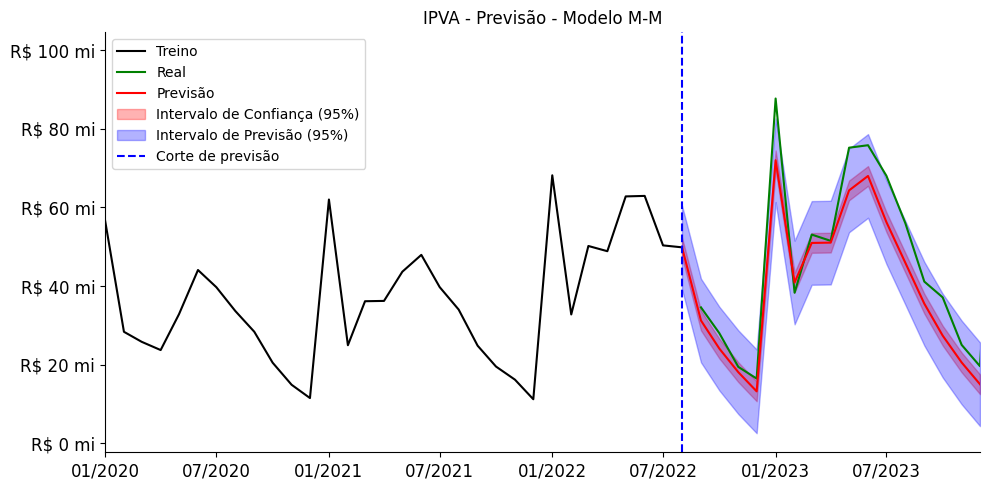

In [72]:
fig, ax = plt.subplots(figsize=(10, 5))

# Base de dados para os graficos
ini_treino = '2020-01-01'
fim_treino = '2022-08-01'
fim_prev = '2023-12-01'
ini_prev = '2022-09-01'

df_graf_treino = df_ipva.loc[(df_ipva.index >= ini_treino) & (df_ipva.index <= fim_treino)]
df_graf_real = df_ipva.loc[(df_ipva.index >= ini_prev)]
df_graf_prev = df_prev_real.loc[df_prev_real.index >= '2022-07-01']['Previsao'].copy()


# Treino
sns.lineplot(x=df_graf_treino.index, y=df_graf_treino, label='Treino', ax=ax, color='black')
# Real
sns.lineplot(x=df_graf_real.index, y=df_graf_real, label='Real', ax=ax, color='green')
# Previsão
sns.lineplot(x=df_graf_prev.index, y=df_graf_prev.values, label='Previsão', ax=ax, color='red')
# Intervalo de Confiança
plt.fill_between(df_prev_real.index, df_prev_real['conf_lower'], df_prev_real['conf_upper'],
                 color='red', alpha=0.3, label='Intervalo de Confiança (95%)')
# Intervalo de Previsão
plt.fill_between(df_prev_real.index, df_prev_real['pred_lower'], df_prev_real['pred_upper'],
                 color='blue', alpha=0.3, label='Intervalo de Previsão (95%)')

# Formatação
def formatar_milhares(x, pos):
    return f'R$ {x/1000000:.0f} mi'
formatter = mticker.FuncFormatter(formatar_milhares)
year_locator = YearLocator(base=2)
ax.xaxis.set_major_locator(year_locator)
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(min(df_graf_treino.index), max(df_graf_prev.index))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(pd.date_range(start='2020-01-01', end='2023-12-01', freq='6MS'))
ax.set_xticklabels(pd.date_range(start='2020-01-01', end='2023-12-01', freq='6MS').strftime('%m/%Y'))
ax.axvline(x=pd.to_datetime('2022-08-01'), color='blue', linestyle='--', label='Corte de previsão')
ax.legend(loc='upper left')
ax.set_title('IPVA - Previsão - Modelo M-M')
plt.tight_layout()
plt.show()